<a href="https://colab.research.google.com/github/polakamal/17Category-Flower-Dataset/blob/master/SVM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,shutil
import cv2
import tensorflow.compat.v1 as tf
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops  # ops (short for operations)
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import mahotas
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
ops.reset_default_graph()

In [ ]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [ ]:
# feature-descriptor-3: Color Histogram
bins = 8
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()


In [ ]:
dir1=  "/content/drive/My Drive/Colab Notebooks"
labels = []
images = []
global_features  = []
dir=  "/content/drive/My Drive/Colab Notebooks/images/jpg"
for folder in os.listdir(dir):
  dir2 = os.path.join(dir,folder)
  current_label = folder
  for img in os.listdir(dir2):
   img = cv2.imread(os.path.join(dir2,img))
   img = cv2.resize(img,(256,256))
   fv_hu_moments = fd_hu_moments(img)
   fv_haralick   = fd_haralick(img)
   fv_histogram  = fd_histogram(img)
   global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
   images.append(img)
   global_features.append(global_feature)
   labels.append(current_label)
   
   

snowdrop


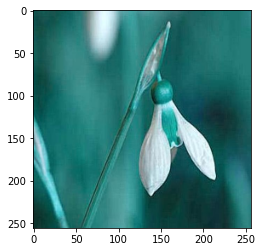

In [ ]:
print(labels[0])
plt.imshow(images[0])


In [ ]:
targetNames = np.unique(labels)
le          = LabelEncoder()
label      = le.fit_transform(labels)

13
sunflower


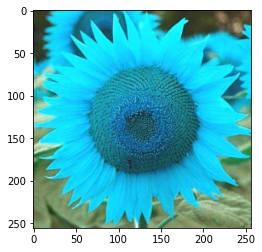

In [ ]:
print(label[80])
print(labels[80])
plt.imshow(images[80])
plt.show()

In [ ]:
global_features = np.array(global_features)
label = np.array(label)
train_x,test_x,train_y,test_y = train_test_split(global_features,label,test_size=0.4,random_state=100,shuffle= True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

In [ ]:
tf.disable_eager_execution()
sess = tf.Session()
test_y = sess.run(tf.one_hot(test_y, 17 ))
train_y = sess.run(tf.one_hot(train_y , 17))
sess.close()

In [ ]:
print(train_x.shape)
print(train_y.shape)


(816, 532)
(816, 17)


In [ ]:
epochs = 60
batch_size = 100
batches = int(train_x.shape[0]/ batch_size)
print(batches)
print(train_x.shape[0])

8
816


f(x,W,b)=Wx+B

In [ ]:

X=tf.placeholder(tf.float32,shape=(None,532))
Y=tf.placeholder(tf.float32, [None,17])
W=tf.Variable(tf.truncated_normal([532,17]))
B = tf.Variable(tf.zeros(17))


In [ ]:
model_output = tf.matmul(X, W) + B

loss fucntion


In [ ]:
alpha = tf.constant([0.01])
delta = tf.constant([1.0], tf.float32)
regulation_term = alpha * tf.nn.l2_loss(W)
true_label = tf.reduce_sum(tf.multiply(Y,model_output),axis=1 ,keepdims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, model_output - true_label + delta), 1) - delta )
loss += regulation_term

In [ ]:
learning_rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0]) 
    

train model

In [ ]:
with tf.Session() as sh:
    sh.run(tf.global_variables_initializer())
    for epoch in range(epochs):
       for i in range(batches):
        offset =i*epoch
        x=train_x[offset:offset + batch_size]
        y= train_y[offset:offset + batch_size]
        sh.run(optimizer, feed_dict={X: x, Y:y})
        c =sh.run(loss, feed_dict={X: x, Y:y})
        
       if epoch % 1 == 0:
         acc = accuracy(sh.run(model_output,feed_dict={X: train_x, Y:train_y}), train_y)
         print(f'epoch:{epoch} loss={c} Acc={acc}')
    print('Test Accuracy = ', accuracy(sh.run(model_output,feed_dict={X: test_x, Y:test_y}),test_y))
    predict = sh.run(model_output,feed_dict={X: test_x, Y:test_y})

epoch:0 loss=[55.43335] Acc=12.622549019607844
epoch:1 loss=[40.46586] Acc=17.034313725490197
epoch:2 loss=[38.803844] Acc=21.20098039215686
epoch:3 loss=[36.98171] Acc=23.897058823529413
epoch:4 loss=[42.358463] Acc=25.612745098039216
epoch:5 loss=[49.668312] Acc=27.083333333333332
epoch:6 loss=[44.161484] Acc=28.186274509803923
epoch:7 loss=[43.6079] Acc=29.28921568627451
epoch:8 loss=[41.002975] Acc=30.147058823529413
epoch:9 loss=[37.196815] Acc=31.004901960784313
epoch:10 loss=[35.970448] Acc=32.23039215686274
epoch:11 loss=[42.508354] Acc=33.333333333333336
epoch:12 loss=[43.09632] Acc=33.57843137254902
epoch:13 loss=[36.969536] Acc=34.31372549019608
epoch:14 loss=[35.114433] Acc=34.9264705882353
epoch:15 loss=[37.470146] Acc=36.39705882352941
epoch:16 loss=[34.547127] Acc=37.622549019607845
epoch:17 loss=[33.14212] Acc=38.48039215686274
epoch:18 loss=[32.39174] Acc=40.0735294117647
epoch:19 loss=[32.438026] Acc=41.05392156862745
epoch:20 loss=[31.09468] Acc=41.544117647058826
ep

In [ ]:
predClass = np.argmax(predict , 1)
true_label = np.argmax(test_y,1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(true_label,predClass)

In [ ]:
print(confusion_matrix)

[[12  0  3  1  4  1  0  0  1  2  2  3  2  0  1  0  0]
 [ 1  8  3  0  0  2  0  5  0  4  3  0  0  4  0  1  0]
 [ 0  0 14  1  0  1  0  2  0  2  1  0  0  1  0  1  0]
 [ 1  0  1 15  0  3  0  2  0  0  3  0  0  3  2  5  0]
 [ 3  0  0  3  9  4  1  2  1  5  0  7  1  0  0  0  1]
 [ 0  2  2  3  0  4  0  4  0  2  0  0  2  1  2  5  1]
 [ 2  0  0  0  1  2  6  2  0  1  3  0  3  0  0  1  9]
 [ 0  4  5  1  0  1  0 16  0  0  1  0  0  5  1  2  0]
 [ 2  1  0  1  1  0  0  0 20  0  1  0  0  0  1  0  0]
 [ 3  1  0  0  3  1  0  0  6  8  2  3  1  0  2  1  1]
 [ 2  3  0  4  0  1  1  1  1  1 10  0  6  0  2  0  4]
 [ 2  2  0  0  6  1  1  0  3  1  1  8  1  0  1  1  5]
 [ 0  2  1  3  3  1  2  0  0  0  5  3  5  1  1  1  2]
 [ 0  2  5  0  0  5  2  1  0  1  0  0  0 10  5  2  2]
 [ 0  7  3  2  0  2  3  0  2  0  2  1  1  1  8  3  2]
 [ 0  2  7  1  1  2  0  2  0  2  0  1  0  1  1  8  2]
 [ 0  0  0  0  2  1  4  0  0  1  2  0  7  0  0  1 14]]
